# EDA : Original

EDA on original KRX data

In [124]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.impute import SimpleImputer

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [140]:
## custom library

import eda_util as eutil

In [2]:
pd.set_option('display.float_format', lambda x: f'{x:,g}')

In [3]:
BASE_PATH = Path('.').resolve()
DATA_PATH = BASE_PATH / 'data'

In [4]:
krx_df = pd.read_csv(DATA_PATH / 'train.csv')
krx_df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [5]:
krx_df.tail()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200
987999,20230530,A238490,힘스,2611843,6410,8220,6300,8220


In [6]:
krx_df.columns = ['date', 'code', 'name', 'volume', 'open', 'high', 'low', 'close']

In [7]:
krx_df['date'] = pd.to_datetime(krx_df['date'], format='%Y%m%d')

In [8]:
len(krx_df['name'].unique()) # 종목수. 개수상 KOSPI, KOSDAQ 섞여있는 것으로 보임. 

2000

In [9]:
krx_df['date'].unique()[:30] # 모든 날짜가 아닌 거래일만 찍혀있는 것을 확인 가능. 

array(['2021-06-01T00:00:00.000000000', '2021-06-02T00:00:00.000000000',
       '2021-06-03T00:00:00.000000000', '2021-06-04T00:00:00.000000000',
       '2021-06-07T00:00:00.000000000', '2021-06-08T00:00:00.000000000',
       '2021-06-09T00:00:00.000000000', '2021-06-10T00:00:00.000000000',
       '2021-06-11T00:00:00.000000000', '2021-06-14T00:00:00.000000000',
       '2021-06-15T00:00:00.000000000', '2021-06-16T00:00:00.000000000',
       '2021-06-17T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-06-21T00:00:00.000000000', '2021-06-22T00:00:00.000000000',
       '2021-06-23T00:00:00.000000000', '2021-06-24T00:00:00.000000000',
       '2021-06-25T00:00:00.000000000', '2021-06-28T00:00:00.000000000',
       '2021-06-29T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-07-02T00:00:00.000000000',
       '2021-07-05T00:00:00.000000000', '2021-07-06T00:00:00.000000000',
       '2021-07-07T00:00:00.000000000', '2021-07-08

기본 OHLC + V 데이터 제공. 

- adj Close 처리 안되어 있을 듯 함. 별도 소스에서 찾아야 함. 
    - `fdr` 이용한 naver 수정종가 이용이 유력 - `korquanttools` 와 같은 방법, 다만 추후 데이터 처리 방법도 나와야 하므로 자체 패키지 쓰는 것이 안좋을 수 있음. 
- survivorship bias 존재하는지 확인 필요. 
- KRX event (거래정지 등) 적용 여부 & 가격 데이터 처리 방법 확인 필요. 

## 예상 문제점 확인

결론: 문제 많음. 
- 수정주가 미적용
- survivorship bias 존재

따라서 이 데이터셋은 무시하고 그냥 동일기간에 대해 `korquanttools` 사용해야 정확한 backtest 가능. 

### 1. adj close 미적용

https://kind.krx.co.kr/disclosure/details.do?method=searchDetailsMain

- 6	2023-02-28 17:17	유가증권 국보	주식병합 결정	국보 001140	 
- 5	2023-02-28 16:07	유가증권 일성신약	주식분할 결정	일성신약 003120

<Axes: >

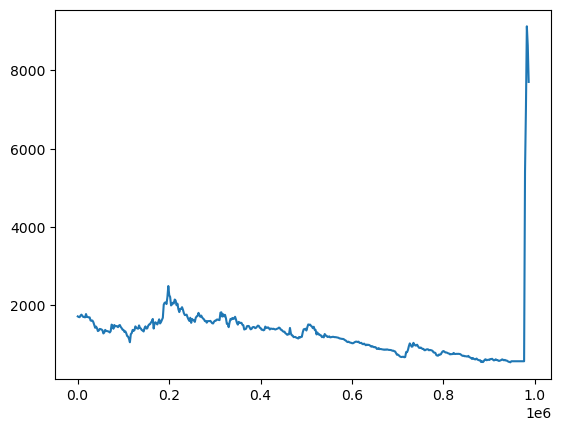

In [10]:
krx_df[krx_df['code'] == 'A001140']['close'].plot()

### 2. survivorship bias

http://open.krx.co.kr/contents/MKD/04/0403/04030300/MKD04030300.jsp

- 208860	엔지스테크널러지	2023/04/18	상장폐지 사유발생
- 117670	알파홀딩스	2023/04/14	상장폐지 사유발생

In [11]:
'A208860' in krx_df['code'].unique()

False

In [12]:
'A117670' in krx_df['code'].unique()

False

<Axes: >

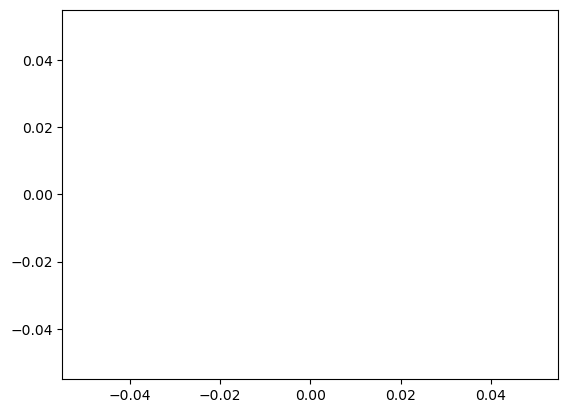

In [13]:
krx_df[krx_df['code'] == 'A208860']['close'].plot()

<Axes: >

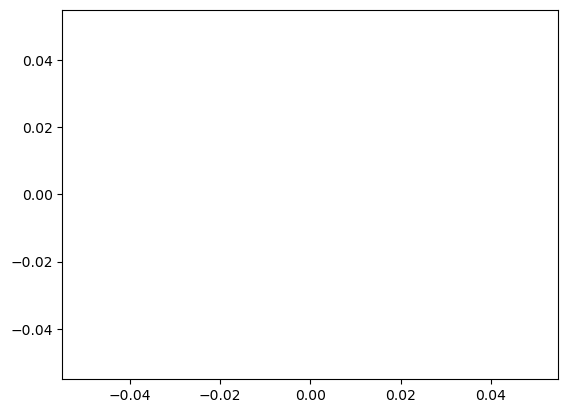

In [14]:
krx_df[krx_df['code'] == 'A117670']['close'].plot()

## 평가방식에 대한 규정 

대회 규정

https://dacon.io/competitions/official/236117/overview/rules

예선 평가 규정

https://dacon.io/competitions/official/236117/talkboard/408727?page=1&dtype=recent

본선 평가 규정 (추후 업데이트)

https://dacon.io/competitions/official/236117/talkboard/408728

### 예선 평가방식 

규정에 의해 알고리즘이 제한되고, 투자 방식도 투기적이 되어야 하는 문제점이 있다. 

본선에선 코스콤 Cloud 상의 더 많은 propriety 데이터 (not 공공) 이 제공되기 떄문에 아예 알고리즘 새로 짜야 함. 

게다가 예선과 달리 실제 program을 돌리는 방식이기 때문에 data frequency 등 알고리즘의 성격도 달라질 수 있다. 

#### 1. 짧은 real OS 기간

- public에서의 simOS 는 5/31 ~ 6/21
- private의 realOS 는 대회 종료 후 7/31 ~ 8/21

대회 평가를 빨리 해야 한다는 압박 때문에 real OS 기간을 1달로 짧게 잡고, 이에 맞춰 simOS 기간을 똑같이 1달로 잡은 것으로 보인다. 

한달 성과, 그것도 simOS와 realOS가 한 달 밖에 떨어져있지 않기 떄문에 

- 5/31~8/21의 regime에 overfitting 시켜야 한다. (최근의 regime이 어떤지에 대한 고민 필요.)
    - 예견편향 있는지 본다고 하였으나, 주어진 데이터부터 예견편향이 내재되어 있음. (survivorship bias)
- realOS의 경우 근미래라 이미 공시 일정이 나와있기 때문에 economic calendar 를 통한 data snooping에 가까운 event 처리가 가능하다. 

#### 2. 200:200 동일 가중 long short 제한

- money neutral하지만 market neutral하지 않을 수 있다. market neutral 맞추기 어렵다. 
- weight 조절이 불가하므로 signal의 강도 조절이 불가능하고, 대신 방향성을 잘 맞춰야 한다. (+/-)

#### 3. Sharpe 산정방식

- simOS, realOS에서 매수/공매도 수익률 산정방식이 cum return이 아니고 holding period return이다. (최대 15일)
    - 이 기간동안 daily trading 못한다. 마지막 날에 정한 long/short 포지션대로 holding하고 15일 뒤 결과를 봐야 한다. 
    - 따라서 알고리즘의 frequency도 이에 맞춰 줄어들어야 한다. daily signal 잡아서 high turnover로 포지션 휙휙 바뀌게 만들 수 없음. 
        - 수수료 및 증권거래세 없다는 가정 있었기 때문에 아쉬운 부분. 
        - 하지만 본선에선 프로그램 돌리는 방식이기 때문에, 본선에선 가능할 것으로 보인다. 
- risk free rate가 3.5%로 고정되어 있다. 
    - 이 rate가 현재 기준금리이고, simOS기간과 realOS 에 적용되기 때문에 평가에선 문제가 없겠지만 
    - 실제 기준금리는 data 시작일 2021/06 ~ 2023/05 까지 매우 급격하게 상승했다. (0.5% --> 3.5%)
        - https://www.bok.or.kr/portal/singl/baseRate/progress.do?dataSeCd=01&menuNo=200656
    - 따라서 backtesting 할 때는 risk free rate 를 고정으로 두지 않고 실제 history에 따라 변동으로 두어야 오래된 시점과 최근 시점의 vertical한 비교가 가능해진다. 
        - 그대로 3.5%로 두고 하면 오래된 성과가 underrated 될 수 있음. 


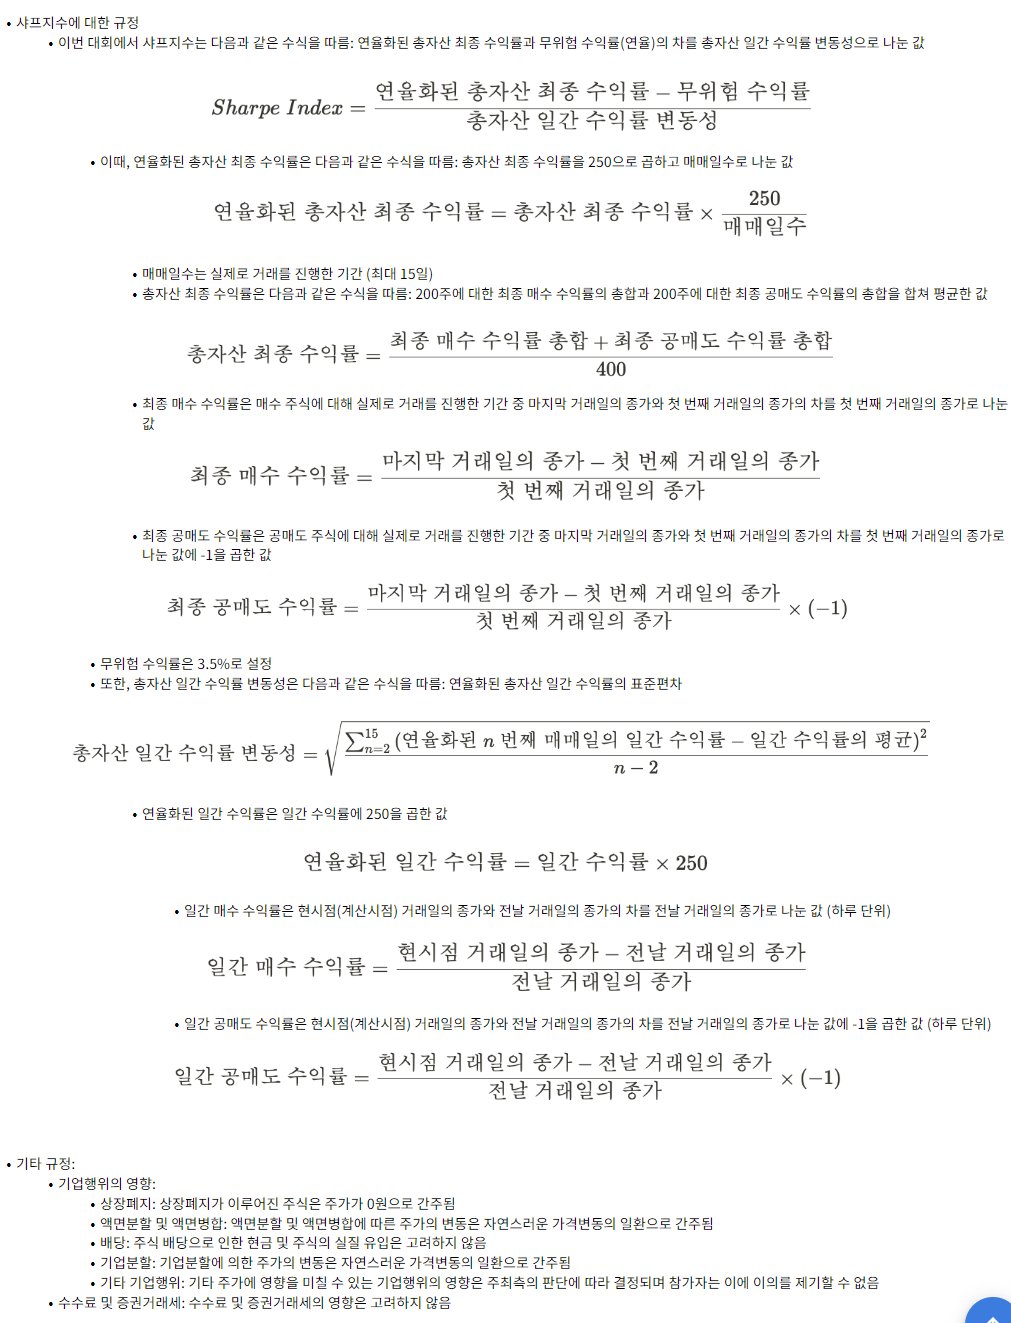







## 추가 아이디어들

- 금통위 기준금리 발표 일정 활용: 주식시장 변동성 커질 수 있음. 
    - 한국은행 금통위 일정
    - FED 일정 
- Correlation Clustering 활용
- (공공데이터로 구할 수 있다면) 종목별 sector로 묶어 sector neutralize 

## 정답 포트폴리오

5/31 ~ 6/21 사이는 simOS인데, 일단 이 simOS에 fitting 시킬 수 있는 전략을 만들어보자. 

5/31~6/21 simOS 기간에 최적으로 나오는 "정답" 포트폴리오를 만들겠다. 

In [32]:
return_df = pd.read_pickle(DATA_PATH / 'return_20140101_20230705.pickle')
close_df = pd.read_pickle(DATA_PATH / 'adjClose_20140101_20230705.pickle')

In [16]:
## date list

holidays = return_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

In [17]:
START = pd.to_datetime('2021-06-01', format='%Y-%m-%d')
END = pd.to_datetime('2023-06-21', format='%Y-%m-%d')

In [18]:
tradingdays = tradingdays[(tradingdays >= START) & (tradingdays <= END)]
tradingdays

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14',
               ...
               '2023-06-08', '2023-06-09', '2023-06-12', '2023-06-13',
               '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-19',
               '2023-06-20', '2023-06-21'],
              dtype='datetime64[ns]', name='trdDd', length=485, freq=None)

In [19]:
dacon_sid_list = [ii[1:] for ii in krx_df['code'].unique()]

In [34]:
return_df = return_df.loc[tradingdays, :].dropna(axis='columns', how='all')
return_df = return_df.loc[:, dacon_sid_list]

close_df = close_df.loc[tradingdays, :].dropna(axis='columns', how='all')
close_df = close_df.loc[:, dacon_sid_list]

In [36]:
simOS_START = '2023-05-31'
simOS_END = '2023-06-21'

### sim OS에서의 정답 레이블

In [22]:
simOS_return_df = return_df.loc[simOS_START:, :].copy()
simOS_cumreturn_df = np.exp(np.log(1+simOS_return_df).cumsum()) - 1

final_day_cumreturn = simOS_cumreturn_df.iloc[-1, :]
final_day_rank = final_day_cumreturn.rank(method='first', ascending=False)

winners = final_day_rank[final_day_rank < 200].index.values
losers = final_day_rank[final_day_rank > 1800].index.values

In [23]:
final_day_cumreturn.loc[winners].mean()

0.2917740561646479

In [24]:
(-1)*final_day_cumreturn.loc[losers].mean()

0.15132615473239552

In [25]:
# sim OS 퍼포먼스 최대치

final_day_cumreturn.loc[winners].mean() + (-1)*final_day_cumreturn.loc[losers].mean()

0.44310021089704343

### sim OS에서 delisted 된 종목들 처리

In [81]:
(return_df.loc['2023-05-30', :] == 0.0).sum()

160

In [91]:
portfolio_day_zero_return_sids = simOS_return_df.columns[(return_df.loc['2023-05-30', :] == 0.0)].values
len(portfolio_day_zero_return_sids)

160

최종적으론 Top200/Bottom200에 속하더라도, 포트폴리오 분배 당일 하필 수익률이 0.0% 인 종목들이 있다. 

다양한 사유로 거래정지가 된 종목들인데, 진짜 문제 있어서 거래정지 된 것들도 있지만 주식 병합 등의 사유로 일정 기간 매매정지가 된 것들도 있다. 

나중에 포트폴리오 rank 찍을 땐, 마지막 포지션 찍는 날에 거래정지인 stock 들은 top 200, bottom 200에 들어가지 않도록 각별히 유의해야 한다. 

그 날 거래 불가한 종목이기 때문.

---

예를들어, cum return winner group에 속한 `060900 (DGP)` 종목을 보자. 

https://finance.naver.com/item/news.naver?code=060900

알고보니, 

- (주)디지피 주권매매거래정지(주식의 병합, 분할 등 전자등록 변경, 말...	KOSCOM	2023.05.09

- (주)디지피 주권매매거래정지해제(액면병합 주권 변경상장)	KOSCOM	2023.05.31


거래정지 이벤트가 있었다. 

포트폴리오 배분하는 5/30에는 거래가 불가능했다. 

In [92]:
len(set(winners) & set(portfolio_day_zero_return_sids))

11

In [93]:
len(set(losers) & set(portfolio_day_zero_return_sids))

12

### 정답 포트폴리오의 특성

- winner 주식의 특성
- loser 주식의 특성

을 통해 현 regime에서 어떤 특성의 portfolio 를 만드는 것이 유리할지 확인. 

#### 데이터 불러오기

In [ ]:
volume_df = pd.read_pickle(DATA_PATH / 'volume_df_20140101_20230705.pickle')
dollarvolume_df = pd.read_pickle(DATA_PATH / 'dollarvolume_df_20140101_20230705.pickle')
marketcap_df = pd.read_pickle(DATA_PATH / 'marketcap_df_20140101_20230705.pickle')
market_cat_df = pd.read_pickle(DATA_PATH / 'market_cat_df_20140101_20230705.pickle')

In [ ]:
volume_df = volume_df.loc[tradingdays, :].dropna(axis='columns', how='all')
volume_df = volume_df.loc[:, dacon_sid_list]

dollarvolume_df = dollarvolume_df.loc[tradingdays, :].dropna(axis='columns', how='all')
dollarvolume_df = dollarvolume_df.loc[:, dacon_sid_list]

marketcap_df = marketcap_df.loc[tradingdays, :].dropna(axis='columns', how='all')
marketcap_df = marketcap_df.loc[:, dacon_sid_list]

In [ ]:
market_cat_inrange = market_cat_df[market_cat_df['trdDd'].isin(tradingdays)]

In [ ]:
KOSPI_sid_list = market_cat_inrange[market_cat_inrange['is_KOSPI'] == True]['ISU_SRT_CD'].unique()
KOSDAQ_sid_list = market_cat_inrange[market_cat_inrange['is_KOSDAQ'] == True]['ISU_SRT_CD'].unique()
KONEX_sid_list = market_cat_inrange[market_cat_inrange['is_KONEX'] == True]['ISU_SRT_CD'].unique()

In [ ]:
portfolio_day_volume = volume_df.loc['2023-05-30', :]
portfolio_day_dollarvolume = dollarvolume_df.loc['2023-05-30', :]
portfolio_day_marketcap = marketcap_df.loc['2023-05-30', :]

In [ ]:
winner_volumes = portfolio_day_volume[winners]
winner_dollarvolumes = portfolio_day_dollarvolume[winners]
winner_marketcaps = portfolio_day_marketcap[winners]

loser_volumes = portfolio_day_volume[losers]
loser_dollarvolumes = portfolio_day_dollarvolume[losers]
loser_marketcaps = portfolio_day_marketcap[losers]

#### dollarvolume & marketcap

In [ ]:
STATS = eutil.statistics

In [ ]:
eutil.compare_s_stats(
    s_list = [
        winner_dollarvolumes,
        loser_dollarvolumes,
        ],
    statistics=STATS,
    colname_list=[
        'winner_dv', 
        'loser_dv',
        ]
)

,winner_dv,loser_dv
count,199,200
mean,1.13853e+10,9.49158e+09
median,1.68909e+09,1.90892e+09
max,3.04335e+11,2.44411e+11
min,0,0
std,3.50231e+10,2.40764e+10
var,1.22662e+21,5.79675e+20
skew,5.64512,5.86634
kurt,37.4555,47.4196
percentile_01,0,0


In [ ]:
eutil.compare_s_stats(
    s_list = [
        winner_marketcaps,
        loser_marketcaps,
        ],
    statistics=STATS,
    colname_list=[
        'winner_mc', 
        'loser_mc',
        ]
)

,winner_mc,loser_mc
count,199,200
mean,6.22243e+11,5.12632e+11
median,1.66776e+11,1.69628e+11
max,1.45387e+13,2.5216e+13
min,3.61732e+10,4.60082e+10
std,1.56547e+12,1.87421e+12
var,2.45071e+24,3.51267e+24
skew,5.75822,11.7804
kurt,40.3259,153.586
percentile_01,4.79114e+10,4.77828e+10


<Axes: xlabel='2023-05-30 00:00:00', ylabel='Count'>

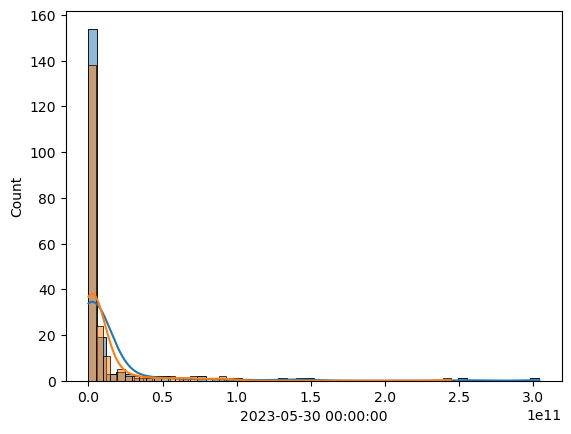

In [ ]:
sns.histplot(winner_dollarvolumes, kde=True, bins=50)
sns.histplot(loser_dollarvolumes, kde=True, bins=50)

<Axes: xlabel='2023-05-30 00:00:00', ylabel='Count'>

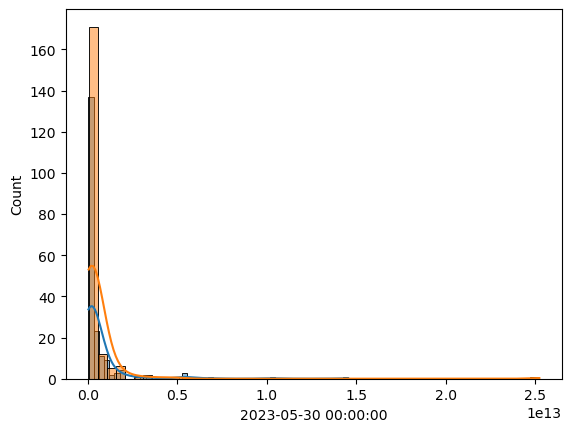

In [ ]:
sns.histplot(winner_marketcaps, kde=True, bins=50)
sns.histplot(loser_marketcaps, kde=True, bins=50)

알아보기 힘든 관계로, log를 씌워 값의 scale을 낮추고 다시 분포를 확인한다. 

0인 것들 있어서 median으로 impute 해줌. 

In [ ]:
imputer = SimpleImputer(missing_values=0, strategy='median')


In [ ]:
imputed_winner_dv = imputer.fit_transform(winner_dollarvolumes.values.reshape(-1, 1))[:, 0]
imputed_loser_dv = imputer.fit_transform(loser_dollarvolumes.values.reshape(-1, 1))[:, 0]

imputed_winner_mc = imputer.fit_transform(winner_marketcaps.values.reshape(-1, 1))[:, 0]
imputed_loser_mc = imputer.fit_transform(loser_marketcaps.values.reshape(-1, 1))[:, 0]

<Axes: ylabel='Count'>

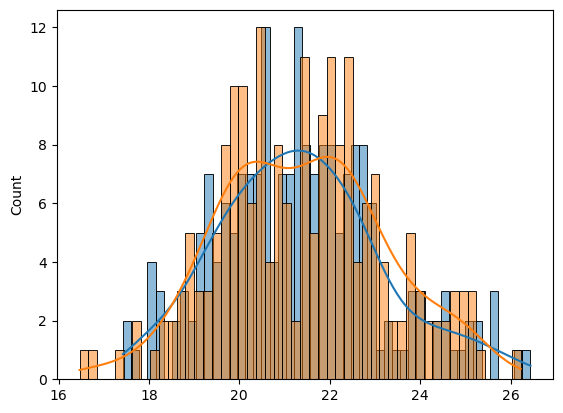

In [ ]:
sns.histplot(np.log(imputed_winner_dv), kde=True, bins=50)
sns.histplot(np.log(imputed_loser_dv), kde=True, bins=50)

<Axes: ylabel='Count'>

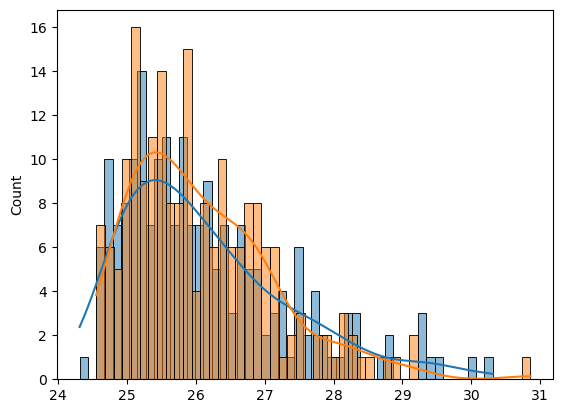

In [ ]:
sns.histplot(np.log(imputed_winner_mc), kde=True, bins=50)
sns.histplot(np.log(imputed_loser_mc), kde=True, bins=50)